In [80]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from pathlib import Path
import pandas as pd

In [13]:
path = Path.home().joinpath("diaz_rincon/VTA_SNc")
folder_path = "traces"

In [14]:
traces_path = list(Path(path).joinpath(folder_path).iterdir())
traces_path

[PosixPath('/home/ic3/diaz_rincon/VTA_SNc/traces/gc_ephys002_03_07_vta_control.npy'),
 PosixPath('/home/ic3/diaz_rincon/VTA_SNc/traces/gc_ephys031_03_07_vta_injected.npy'),
 PosixPath('/home/ic3/diaz_rincon/VTA_SNc/traces/gc_ephys017_03_05_snc_control.npy'),
 PosixPath('/home/ic3/diaz_rincon/VTA_SNc/traces/gc_ephys013_03_04_snc_injected.npy'),
 PosixPath('/home/ic3/diaz_rincon/VTA_SNc/traces/gc_ephys002_03_04_snc_injected.npy'),
 PosixPath('/home/ic3/diaz_rincon/VTA_SNc/traces/gc_ephys017_03_04_snc_injected.npy'),
 PosixPath('/home/ic3/diaz_rincon/VTA_SNc/traces/gc_ephys009_03_02_snc_injected.npy'),
 PosixPath('/home/ic3/diaz_rincon/VTA_SNc/traces/gc_ephys001_03_04_snc_injected.npy'),
 PosixPath('/home/ic3/diaz_rincon/VTA_SNc/traces/gc_ephys004_03_04_snc_injected.npy'),
 PosixPath('/home/ic3/diaz_rincon/VTA_SNc/traces/gc_ephys018_03_04_snc_injected.npy'),
 PosixPath('/home/ic3/diaz_rincon/VTA_SNc/traces/gc_ephys027_03_07_vta_injected.npy'),
 PosixPath('/home/ic3/diaz_rincon/VTA_SNc/tra

Creating traces dictionary

In [15]:
traces = {}
for iter, file_name in enumerate(traces_path):
    traces[iter] = np.load(file_name, allow_pickle=True)    

Each key corresponds to a video

In [16]:
traces.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33])

Every video has a different number of cells and number of frames

In [17]:
for i in range(len(traces)):
    print(traces[i].shape)

(42, 2250)
(25, 2250)
(49, 2250)
(23, 2250)
(28, 2250)
(21, 2250)
(51, 2250)
(10, 750)
(16, 2249)
(21, 2250)
(27, 2250)
(37, 2764)
(28, 2250)
(37, 2250)
(13, 2250)
(31, 2250)
(20, 2250)
(49, 2250)
(55, 2250)
(34, 2250)
(10, 750)
(43, 2250)
(27, 2250)
(27, 2250)
(24, 2250)
(32, 2250)
(31, 2250)
(19, 1019)
(28, 2250)
(39, 2250)
(17, 3000)
(67, 2250)
(38, 2250)
(34, 2250)


Creating groups (vta_injected, snc_injected, vta_control, snc_control)

In [44]:
vta_injected = []
snc_injected = []
vta_control = []
snc_control = []

for iter, file_name in enumerate(traces_path):
    if "vta_injected" in str(file_name):
        vta_injected.append(iter)
    if "snc_injected" in str(file_name):
        snc_injected.append(iter)
    if "vta_control" in str(file_name):
        vta_control.append(iter)
    if "snc_control" in str(file_name):
        snc_control.append(iter)

Control groups

In [48]:
vta_injected, vta_control

([1, 10, 12, 20, 26, 29], [0, 15, 17, 23])

Injected groups

In [49]:
snc_control, snc_injected

([2, 13, 14, 19, 24, 25, 27, 32],
 [3, 4, 5, 6, 7, 8, 9, 11, 16, 18, 21, 22, 28, 30, 31, 33])

Some numbers

In [51]:
print(f"There are:")
print(f"{len(vta_control)} videos with normal quantities of αS in VTA")
print(f"{len(vta_injected)} videos with over expression of αS in VTA")
print(f"{len(snc_control)} videos with normal quantities of αS in SNc")
print(f"{len(snc_injected)} videos with over expression of αS in SNc")

There are:
4 videos with normal quantities of αS in VTA
6 videos with over expression of αS in VTA
8 videos with normal quantities of αS in SNc
16 videos with over expression of αS in SNc


## Plotting Cells

In [18]:
# for i in range(len(traces)):
#     frames_per_second = 25
#     num_cells = traces[i].shape[0]
#     samples = traces[i].shape[1]
#     duration = samples / frames_per_second
#     time = np.arange(start = 0, stop=int(duration), step=1/frames_per_second)
    
#     # Plot the traces
#     fig, axs = plt.subplots(num_cells, figsize=(20, 40))
#     for cell_num in range(num_cells):
#         axs[cell_num].autoscale(enable=None, axis="x", tight=True)
#         # axs[cell_num].set_ylabel(f"ROI {cell_num}", rotation=0)
#         axs[cell_num].title.set_text(f'ROI {cell_num + 1}')
#         # axs[cell_num].set_xlabel("Time")
#         axs[cell_num].plot(time,traces[i][cell_num, 0:len(time)])

Calculating Spearman's Rho between all activity of cells per video and extracting p-value for each correlation

In [19]:
corrs = {}
pvals = {}
# Correlation coefficients
for i in range(len(traces)):
    corrs[i], pvals[i] = stats.spearmanr(np.transpose(traces[i]))

In [27]:
corrs.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33])

In [30]:
corrs[2]

array([[ 1.00000000e+00,  3.61826180e-02,  1.40362501e-01, ...,
        -3.22694415e-03,  1.74689884e-02,  1.45288109e-02],
       [ 3.61826180e-02,  1.00000000e+00,  2.94852597e-02, ...,
         3.92288219e-03,  6.15393082e-02, -3.87651488e-02],
       [ 1.40362501e-01,  2.94852597e-02,  1.00000000e+00, ...,
         1.01635277e-02,  1.78416194e-02,  2.59833918e-02],
       ...,
       [-3.22694415e-03,  3.92288219e-03,  1.01635277e-02, ...,
         1.00000000e+00,  5.91826903e-02,  2.12963707e-04],
       [ 1.74689884e-02,  6.15393082e-02,  1.78416194e-02, ...,
         5.91826903e-02,  1.00000000e+00, -3.76616987e-02],
       [ 1.45288109e-02, -3.87651488e-02,  2.59833918e-02, ...,
         2.12963707e-04, -3.76616987e-02,  1.00000000e+00]])

Displaying the correlations (adjacency matrix)


/tmp/ipykernel_10527/2216343262.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig2 = plt.figure()


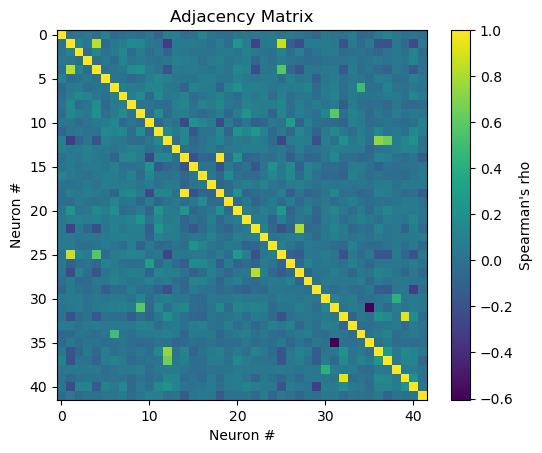

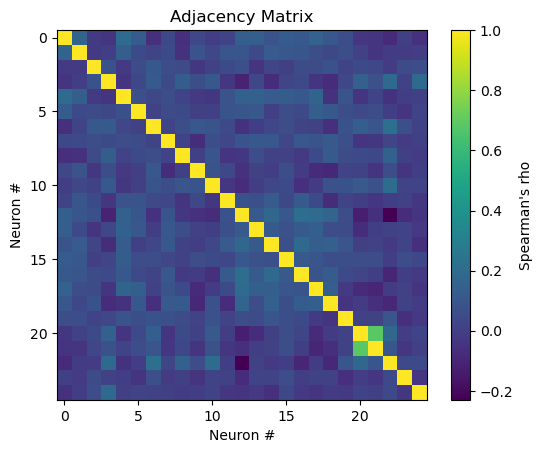

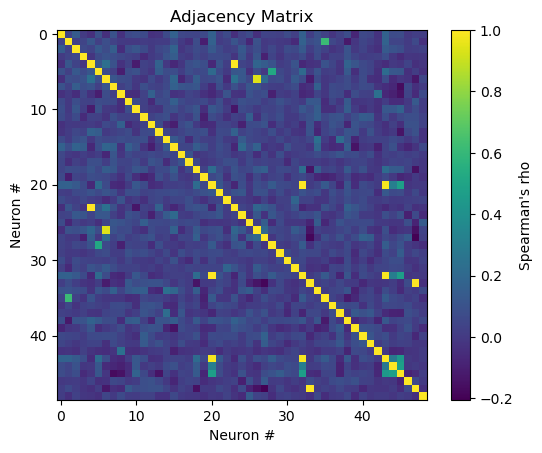

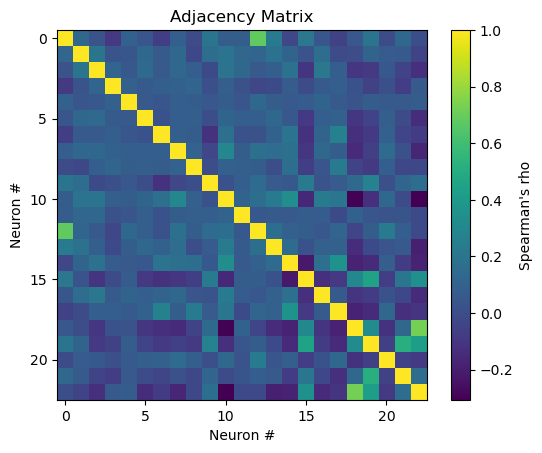

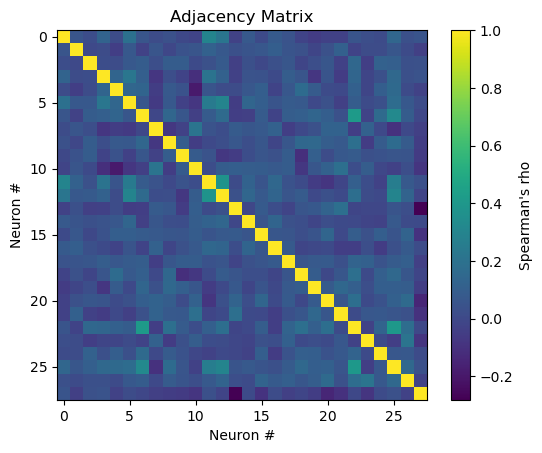

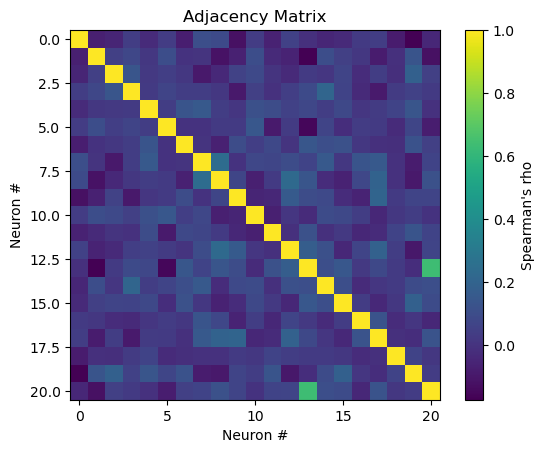

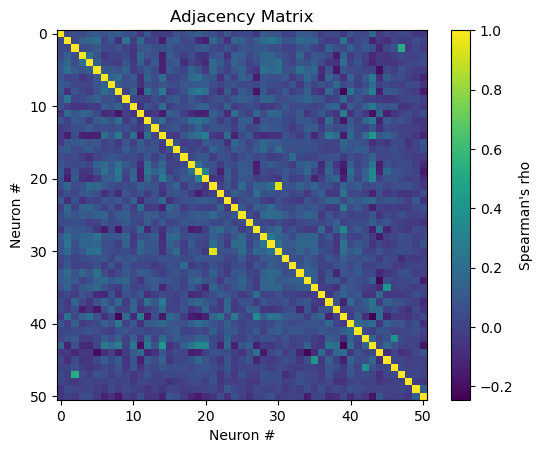

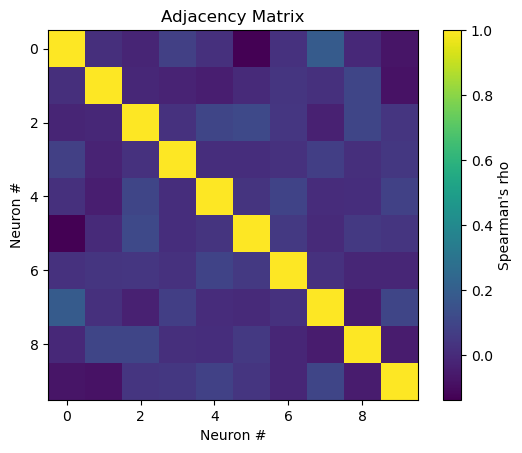

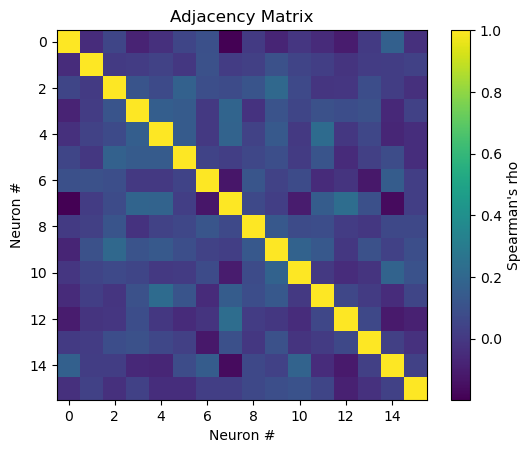

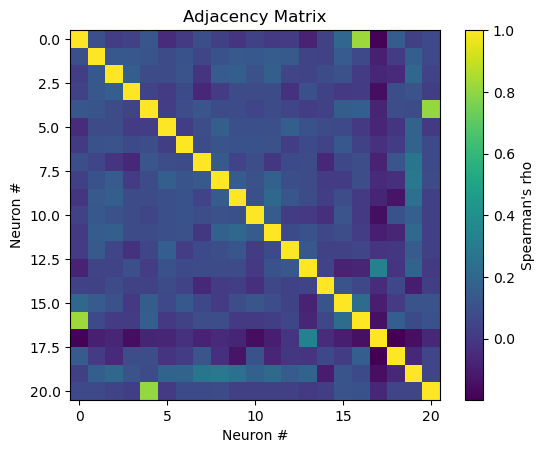

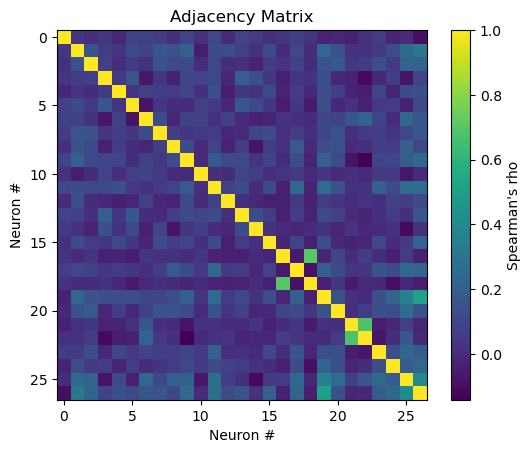

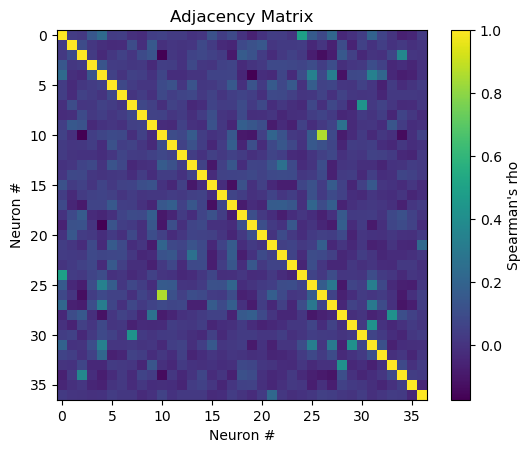

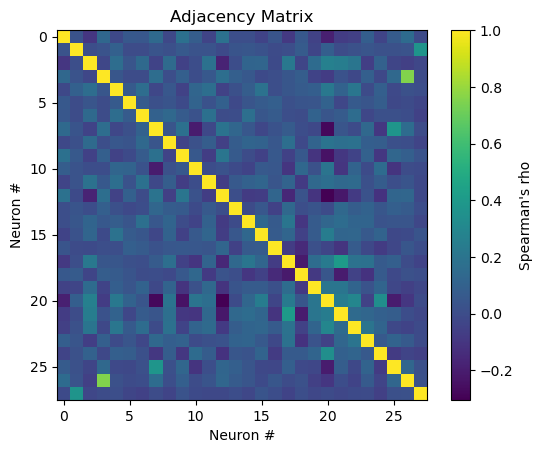

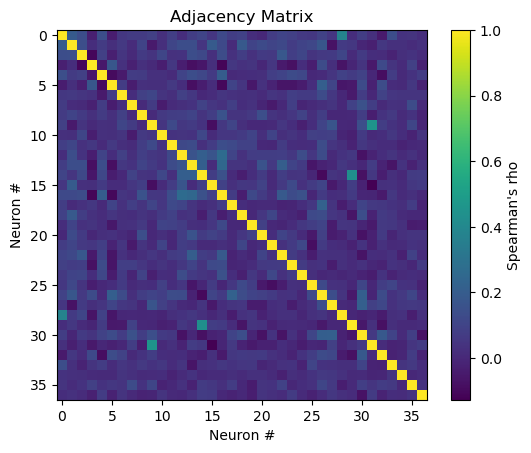

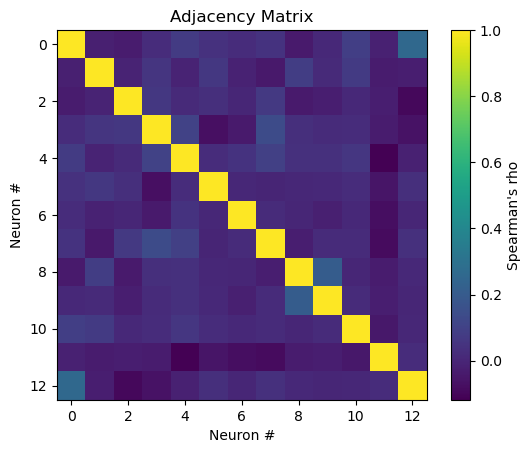

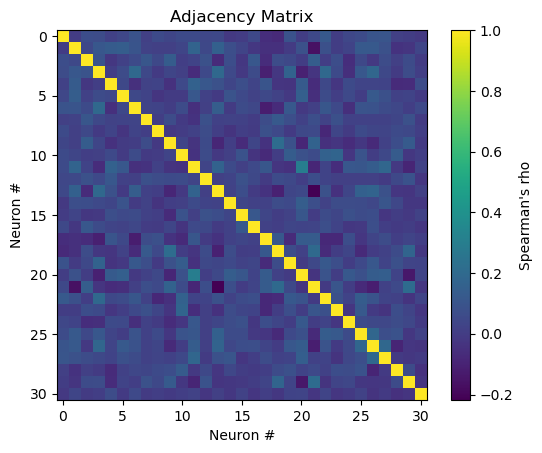

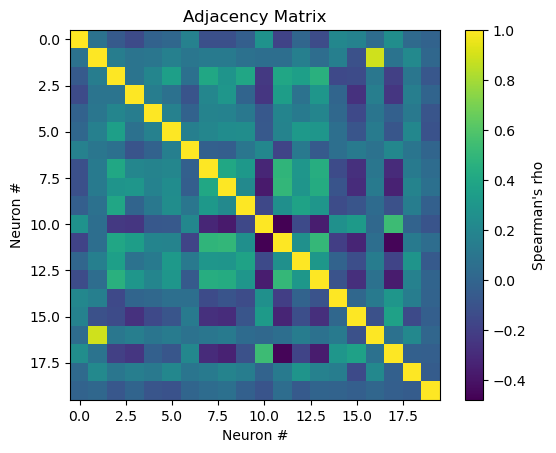

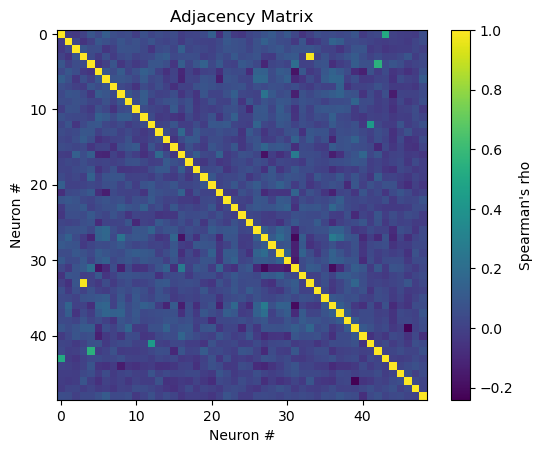

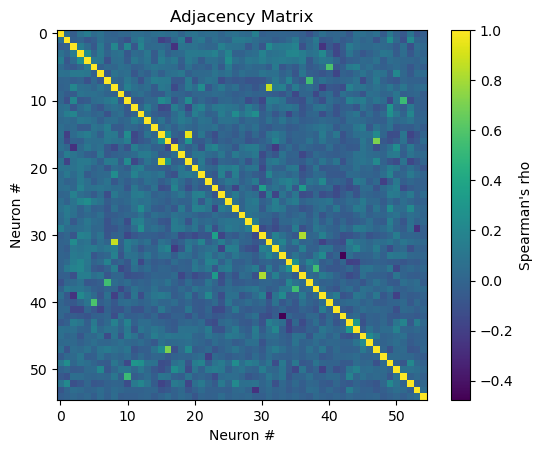

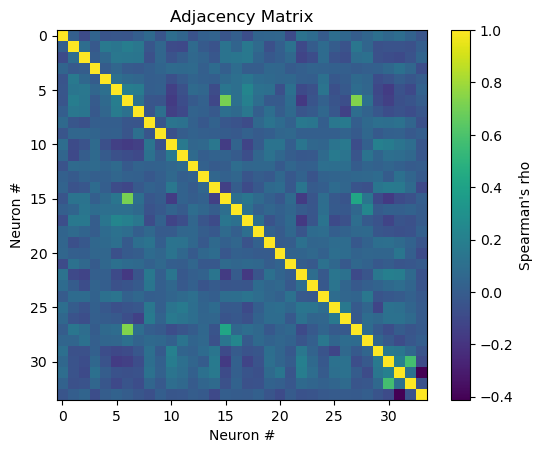

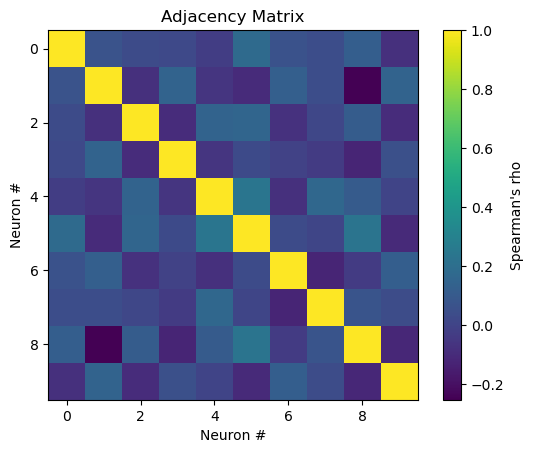

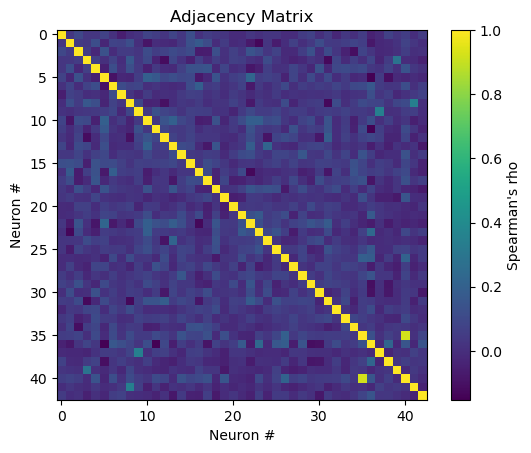

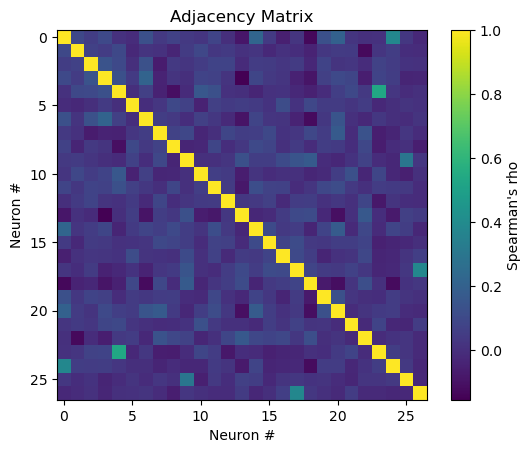

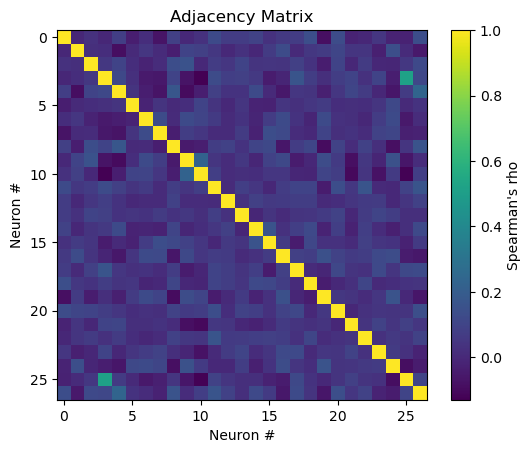

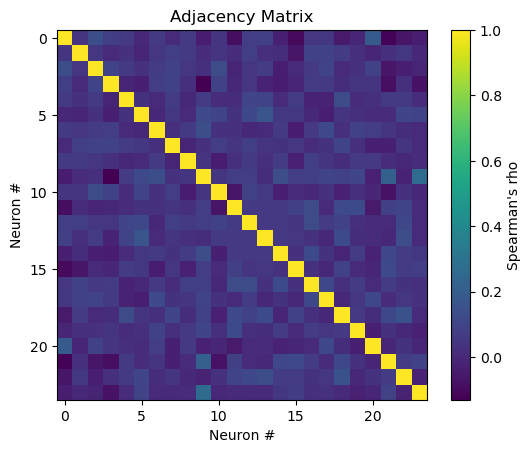

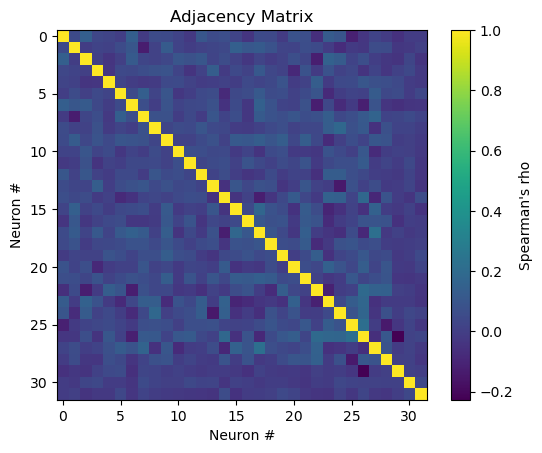

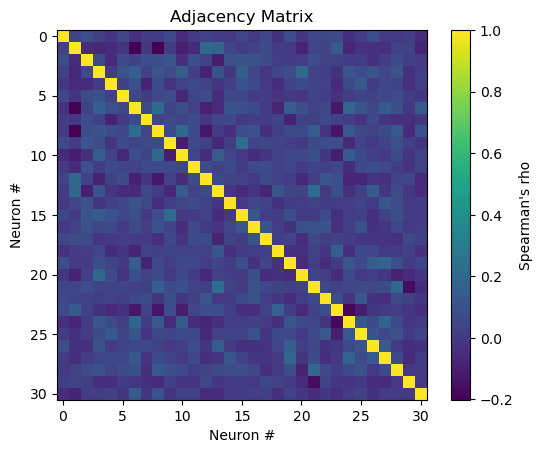

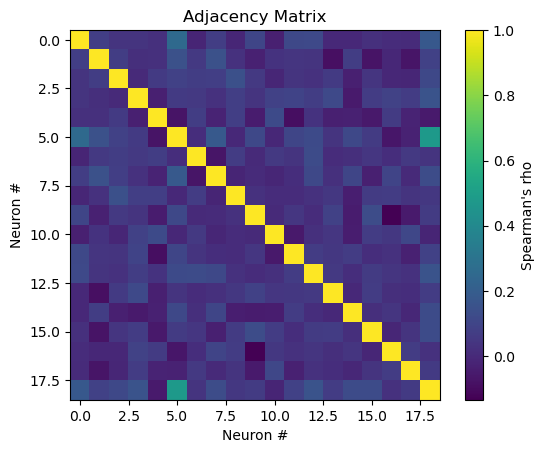

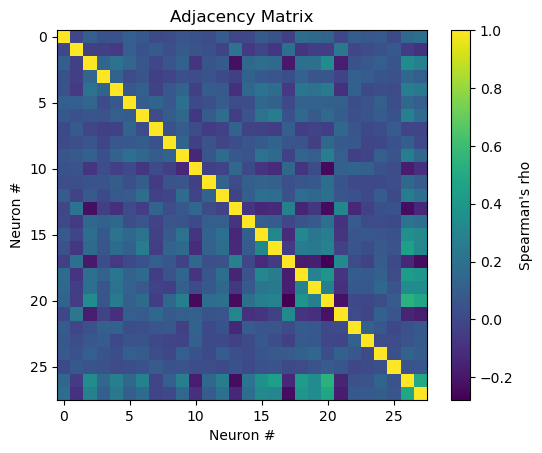

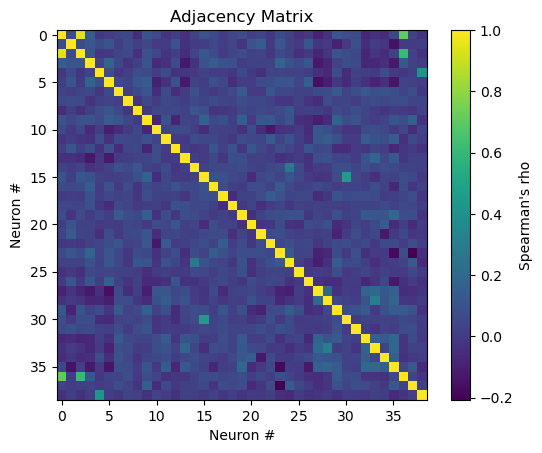

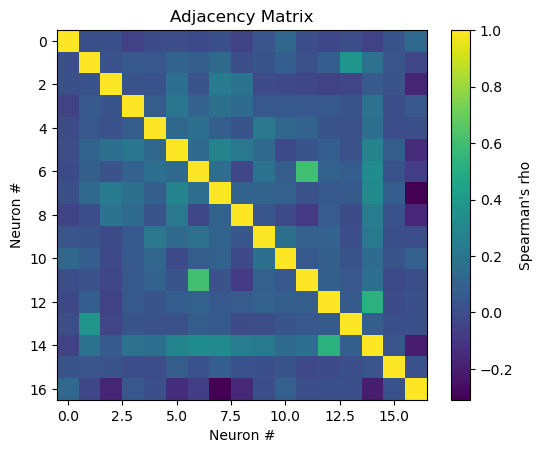

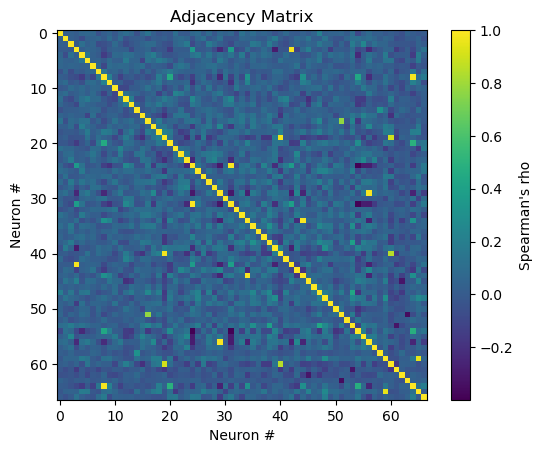

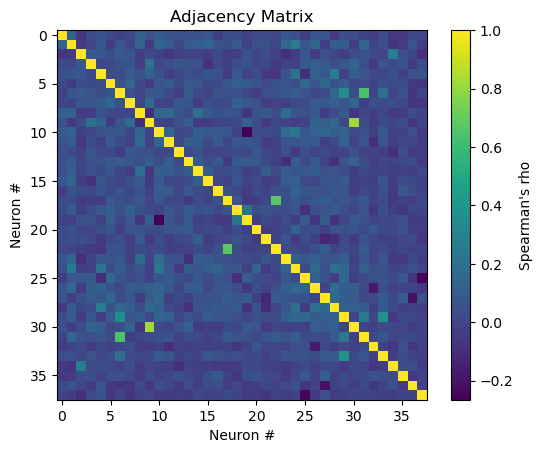

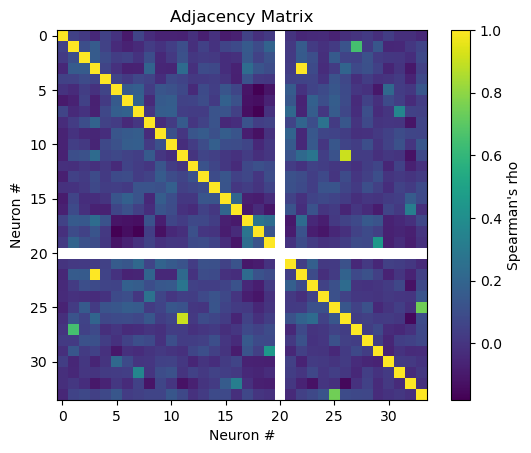

In [20]:
# Each square represents a "cell pair"
for i in range(len(traces)):
    fig2 = plt.figure()
    plt.imshow(corrs[i])
    plt.colorbar(label="Spearman's rho")
    plt.title("Adjacency Matrix")
    # Fix axis so that they don't show floats and start at 1 rather than 0
    plt.xlabel('Neuron #')
    plt.ylabel('Neuron #')

Average the spearman's rho values for the cell pairs. We use the matrix's lower diagonal

In [21]:
lower_triangle = {}
mean_corr = {}
for i in range(len(traces)):
    lower_triangle[i] = np.tril(corrs[i])
    mean_corr[i] = np.mean(lower_triangle[i]) 

Synchrony value for each slice

In [22]:
# Datapoints (one for each video)
mean_corr

{0: 0.03725290066727539,
 1: 0.05882457827384446,
 2: 0.04001235587125907,
 3: 0.07211439543780773,
 4: 0.0600563333206001,
 5: 0.06475982265591963,
 6: 0.0420603160337783,
 7: 0.11060441965617666,
 8: 0.08077987666337424,
 9: 0.07819501386417951,
 10: 0.06770750734928571,
 11: 0.042740294417519524,
 12: 0.056332481930928185,
 13: 0.04731600975975159,
 14: 0.08309138361268342,
 15: 0.04870959949145903,
 16: 0.0821631550603351,
 17: 0.03458476703196466,
 18: 0.02937768110907788,
 19: 0.04418147564727311,
 20: 0.11022874997137451,
 21: 0.040544176696356814,
 22: 0.051713797244149214,
 23: 0.057813068526887244,
 24: 0.059606272578104774,
 25: 0.04588668884691573,
 26: 0.046547080913880774,
 27: 0.07169653199674371,
 28: 0.06920004245384777,
 29: 0.04313265201096501,
 30: 0.09052706083901893,
 31: 0.03180473868575143,
 32: 0.042719119403369615,
 33: nan}

Calculating mean_corr for each group

In [104]:
mean_corr_vta_control = []
mean_corr_vta_injected = []
mean_corr_snc_control = []
mean_corr_snc_injected = []

for i in range(len(vta_control)):
    mean_corr_vta_control.append((mean_corr[vta_control[i]]))

for i in range(len(vta_injected)):
    mean_corr_vta_injected.append((mean_corr[vta_injected[i]]))

for i in range(len(snc_control)):
    mean_corr_snc_control.append((mean_corr[snc_control[i]]))

for i in range(len(snc_injected)):
    mean_corr_snc_injected.append((mean_corr[snc_injected[i]]))

In [56]:
mean_corr_vta_control

[0.03725290066727539,
 0.04870959949145903,
 0.03458476703196466,
 0.057813068526887244]

In [57]:
mean_corr_vta_injected

[0.05882457827384446,
 0.06770750734928571,
 0.056332481930928185,
 0.11022874997137451,
 0.046547080913880774,
 0.04313265201096501]

In [58]:
mean_corr_snc_control

[0.04001235587125907,
 0.04731600975975159,
 0.08309138361268342,
 0.04418147564727311,
 0.059606272578104774,
 0.04588668884691573,
 0.07169653199674371,
 0.042719119403369615]

In [105]:
mean_corr_snc_injected

[0.07211439543780773,
 0.0600563333206001,
 0.06475982265591963,
 0.0420603160337783,
 0.11060441965617666,
 0.08077987666337424,
 0.07819501386417951,
 0.042740294417519524,
 0.0821631550603351,
 0.02937768110907788,
 0.040544176696356814,
 0.051713797244149214,
 0.06920004245384777,
 0.09052706083901893,
 0.03180473868575143,
 nan]

In [106]:
mean_corr_snc_injected = pd.DataFrame(mean_corr_snc_injected).dropna()

In [108]:
mean_corr_snc_injected = mean_corr_snc_injected[0].tolist()

In [109]:
mean_corr_snc_injected

[0.07211439543780773,
 0.0600563333206001,
 0.06475982265591963,
 0.0420603160337783,
 0.11060441965617666,
 0.08077987666337424,
 0.07819501386417951,
 0.042740294417519524,
 0.0821631550603351,
 0.02937768110907788,
 0.040544176696356814,
 0.051713797244149214,
 0.06920004245384777,
 0.09052706083901893,
 0.03180473868575143]

t-test between different groups (SNc, VTA, subgroups: control & injected)

In [110]:
t_test_vta = stats.ttest_ind(mean_corr_vta_control, mean_corr_vta_injected)
t_test_snc = stats.ttest_ind(mean_corr_snc_control, mean_corr_snc_injected)

In [111]:
t_test_vta

Ttest_indResult(statistic=-1.4600785696745777, pvalue=0.182394499283694)

In [112]:
t_test_snc

Ttest_indResult(statistic=-0.9508492050795542, pvalue=0.3524970618114688)